## 1. Environment Setup

In [1]:
# Check execution environment
import sys
from pathlib import Path

# Add src to path for imports
project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
sys.path.insert(0, str(project_root))

from src.utils import is_kaggle, is_local, get_execution_env

env = get_execution_env()
print(f"Execution environment: {env}")
print(f"Project root: {project_root}")

Execution environment: local
Project root: /home/miguel/Desktop/MCIM/Projects/MCIM_Final_Project


In [2]:
# If on Kaggle, clone the repository for access to utilities
if is_kaggle():
    !git clone https://github.com/miguel-silva48/MCIM_Final_Project.git
    %cd MCIM_Final_Project
    sys.path.insert(0, str(Path.cwd()))
    print("Repository cloned successfully")

In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Import project modules
from src.utils import get_data_paths
from src.data import (
    load_raw_data, merge_projections_reports,
    analyze_patient_image_counts, get_projection_statistics,
    extract_report_text, calculate_censoring_ratio,
    filter_reports_by_censoring, clean_metadata_text,
    tokenize_text, build_vocabulary, download_nltk_data,
    get_ngram_frequencies, save_ngram_report
)
from src.visualization import (
    plot_patient_image_distribution, plot_projection_breakdown,
    plot_text_length_distributions, plot_censoring_distribution,
    plot_ngram_frequencies, visualize_sample_xrays
)

# Download NLTK data
download_nltk_data()

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

print("All modules imported successfully!")

All modules imported successfully!


In [4]:
# Load configuration
config_path = project_root / 'configs' / 'data_config.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

print("Configuration loaded:")
print(yaml.dump(config, default_flow_style=False))

Configuration loaded:
max_censoring_ratio: 0.3
min_vocab_freq: 5
projection_strategy: first_frontal
random_seed: 42
splits:
  test: 0.1
  train: 0.8
  val: 0.1
text_preprocessing:
  clean_metadata: true
  lowercase: true
  remove_punctuation: true
text_source: impression



## 2. Data Loading

In [5]:
# Get data paths based on environment
data_paths = get_data_paths()

print("Data paths:")
for key, path in data_paths.items():
    exists = "✓" if path.exists() else "✗"
    print(f"  {exists} {key}: {path}")

Data paths:
  ✓ data_root: /home/miguel/Desktop/MCIM/Projects/MCIM_Final_Project/data
  ✓ images_dir: /home/miguel/Desktop/MCIM/Projects/MCIM_Final_Project/data/images/images_normalized
  ✓ projections_csv: /home/miguel/Desktop/MCIM/Projects/MCIM_Final_Project/data/indiana_projections.csv
  ✓ reports_csv: /home/miguel/Desktop/MCIM/Projects/MCIM_Final_Project/data/indiana_reports.csv


In [6]:
# Load raw data
projections_df, reports_df = load_raw_data(data_paths)

print(f"Projections shape: {projections_df.shape}")
print(f"Reports shape: {reports_df.shape}")
print(f"\nUnique patients in projections: {projections_df['uid'].nunique()}")
print(f"Unique patients in reports: {reports_df['uid'].nunique()}")

Projections shape: (7466, 3)
Reports shape: (3851, 8)

Unique patients in projections: 3851
Unique patients in reports: 3851


In [7]:
# Preview projections data
print("Projections Data Sample:")
display(projections_df.head(10))

print("\nProjection type distribution:")
print(projections_df['projection'].value_counts())

Projections Data Sample:


,uid,filename,projection
0,1,1_IM-0001-4001.dcm.png,Frontal
1,1,1_IM-0001-3001.dcm.png,Lateral
2,2,2_IM-0652-1001.dcm.png,Frontal
3,2,2_IM-0652-2001.dcm.png,Lateral
4,3,3_IM-1384-1001.dcm.png,Frontal
5,3,3_IM-1384-2001.dcm.png,Lateral
6,4,4_IM-2050-1001.dcm.png,Frontal
7,4,4_IM-2050-2001.dcm.png,Lateral
8,5,5_IM-2117-1003002.dcm.png,Frontal
9,5,5_IM-2117-1004003.dcm.png,Lateral



Projection type distribution:
projection
Frontal    3818
Lateral    3648
Name: count, dtype: int64


In [8]:
# Preview reports data
print("Reports Data Sample:")
display(reports_df.head())

print("\nReports columns:")
print(reports_df.columns.tolist())

print("\nMissing values:")
print(reports_df.isnull().sum())

Reports Data Sample:


,uid,MeSH,Problems,image,indication,comparison,findings,impression
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size are within normal limits. There is no pulmonary edem...,Normal chest x-XXXX.
1,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XXXX. Enlarged pulmonary arteries. Clear lungs. Infe...,No acute pulmonary findings.
2,3,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XXXX. Pain to R back, R elbow and R rib XXXX, no pre...",NaN,NaN,"No displaced rib fractures, pneumothorax, or pleural effusion identified. Well-expanded and clea..."
3,4,"Pulmonary Disease, Chronic Obstructive;Bullous Emphysema;Pulmonary Fibrosis/interstitial;Cicatri...","Pulmonary Disease, Chronic Obstructive;Bullous Emphysema;Pulmonary Fibrosis;Cicatrix;Opacity;Opa...","PA and lateral views of the chest XXXX, XXXX at XXXX hours",XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and alveolar opacities consistent with chronic obstruct...,"1. Bullous emphysema and interstitial fibrosis. 2. Probably scarring in the left apex, although ..."
4,5,Osteophyte/thoracic vertebrae/multiple/small;Thickening/pleura/apex/bilateral;Lung/hyperdistenti...,Osteophyte;Thickening;Lung,Xray Chest PA and Lateral,Chest and nasal congestion.,NaN,The cardiomediastinal silhouette and pulmonary vasculature are within normal limits. There is no...,No acute cardiopulmonary abnormality.



Reports columns:
['uid', 'MeSH', 'Problems', 'image', 'indication', 'comparison', 'findings', 'impression']

Missing values:
uid              0
MeSH             0
Problems         0
image            0
indication      86
comparison    1166
findings       514
impression      31
dtype: int64


In [9]:
# Merge projections with reports
merged_df = merge_projections_reports(projections_df, reports_df)

print(f"Merged data shape: {merged_df.shape}")
print(f"Unique patients: {merged_df['uid'].nunique()}")

display(merged_df.head())

Merged data shape: (7466, 10)
Unique patients: 3851


,uid,filename,projection,MeSH,Problems,image,indication,comparison,findings,impression
0,1,1_IM-0001-4001.dcm.png,Frontal,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size are within normal limits. There is no pulmonary edem...,Normal chest x-XXXX.
1,1,1_IM-0001-3001.dcm.png,Lateral,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size are within normal limits. There is no pulmonary edem...,Normal chest x-XXXX.
2,2,2_IM-0652-1001.dcm.png,Frontal,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XXXX. Enlarged pulmonary arteries. Clear lungs. Infe...,No acute pulmonary findings.
3,2,2_IM-0652-2001.dcm.png,Lateral,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XXXX. Enlarged pulmonary arteries. Clear lungs. Infe...,No acute pulmonary findings.
4,3,3_IM-1384-1001.dcm.png,Frontal,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XXXX. Pain to R back, R elbow and R rib XXXX, no pre...",NaN,NaN,"No displaced rib fractures, pneumothorax, or pleural effusion identified. Well-expanded and clea..."


## 3. Patient-Image Distribution Analysis

Understanding how many images each patient has is critical for:
- Preventing data leakage (same patient in train/val/test)
- Deciding on projection strategy (first frontal only vs. paired images)

In [10]:
# Analyze patient image counts
patient_counts = analyze_patient_image_counts(merged_df)

print(f"Patient image count statistics:")
display(patient_counts.describe())

print("\nFirst 20 patients:")
display(patient_counts.head(20))

Patient image count statistics:


,uid,n_frontal,n_lateral,total_images
count,3851.000000,3851.000000,3851.000000,3851.000000
mean,1998.134511,0.991431,0.947286,1.938717
std,1158.010359,0.282253,0.318397,0.418264
min,1.000000,0.000000,0.000000,1.000000
25%,995.500000,1.000000,1.000000,2.000000
50%,1991.000000,1.000000,1.000000,2.000000
75%,3010.500000,1.000000,1.000000,2.000000
max,3999.000000,4.000000,3.000000,5.000000



First 20 patients:


,uid,n_frontal,n_lateral,total_images
0,1,1,1,2
1,2,1,1,2
2,3,1,1,2
3,4,1,1,2
4,5,1,1,2
5,6,1,1,2
6,7,1,1,2
7,8,1,1,2
8,9,1,1,2
9,10,1,1,2


In [11]:
# Get projection statistics
proj_stats = get_projection_statistics(patient_counts)

print("Projection Pattern Statistics:")
print("=" * 50)
for key, value in proj_stats.items():
    pct = (value / proj_stats['total_patients']) * 100
    print(f"{key:30s}: {value:5d} ({pct:5.1f}%)")

Projection Pattern Statistics:
total_patients                :  3851 (100.0%)
ideal_pairs                   :  3194 ( 82.9%)
multiple_frontals             :   122 (  3.2%)
multiple_laterals             :    97 (  2.5%)
frontal_only                  :   301 (  7.8%)
lateral_only                  :   162 (  4.2%)
single_image_only             :   446 ( 11.6%)


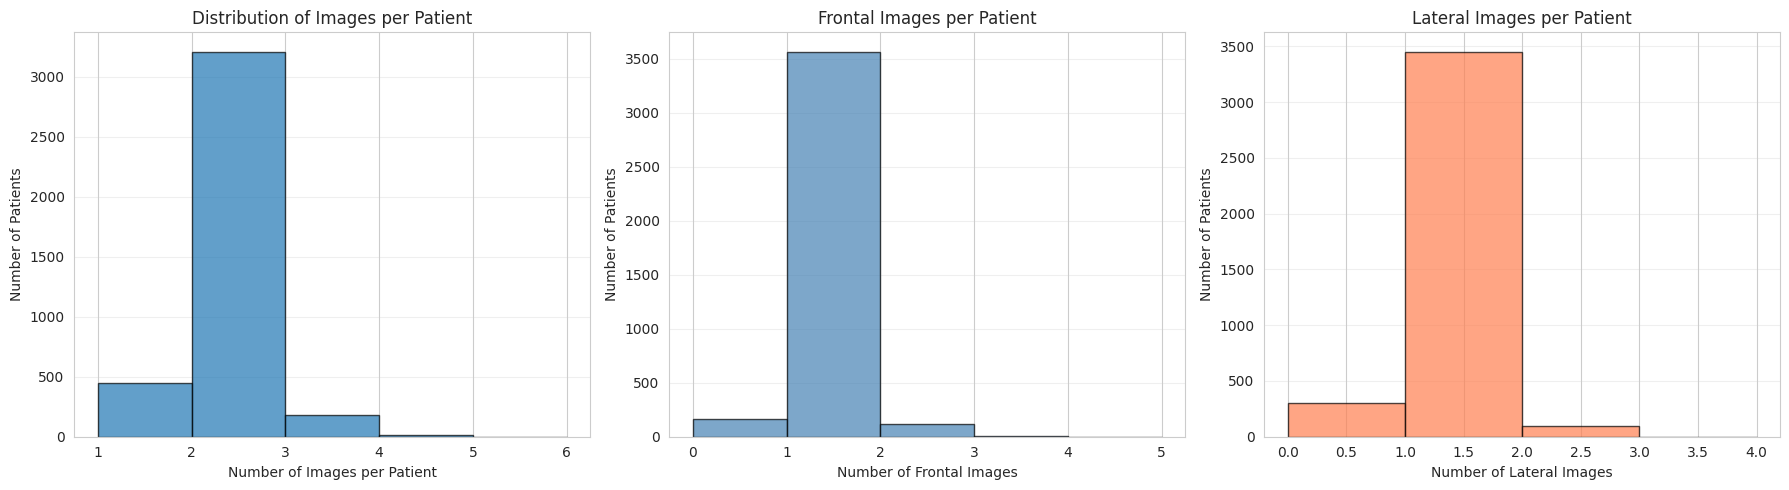

In [12]:
# Visualize patient image distributions
plot_patient_image_distribution(
    patient_counts,
    save_path=project_root / 'data' / 'reports' / 'patient_image_distribution.png'
)

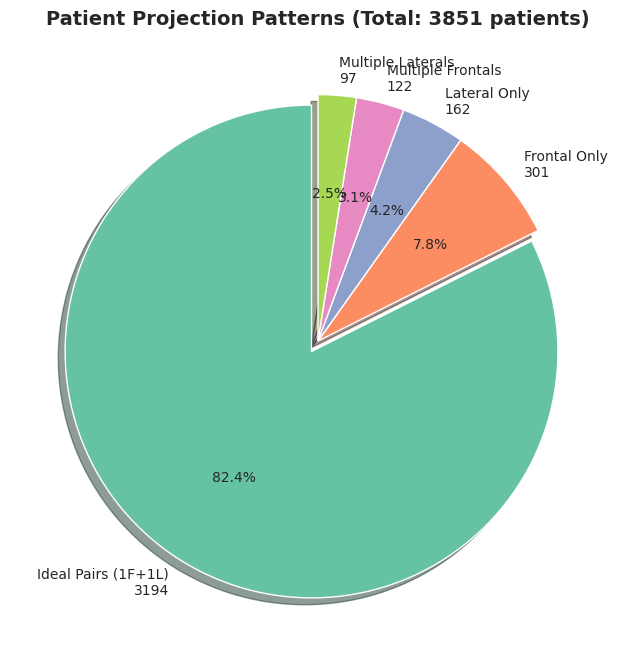

In [13]:
# Visualize projection breakdown
plot_projection_breakdown(
    proj_stats,
    save_path=project_root / 'data' / 'reports' / 'projection_breakdown.png'
)

In [14]:
# Identify problematic cases (multiple frontal images like uid 3549)
multiple_frontals = patient_counts[patient_counts['n_frontal'] > 1].sort_values('n_frontal', ascending=False)

print(f"Patients with multiple frontal images: {len(multiple_frontals)}")
print("\nTop 10 patients with most frontal images:")
display(multiple_frontals.head(10))

# Example: uid 3549 mentioned by user
if 3549 in multiple_frontals['uid'].values:
    uid_3549 = patient_counts[patient_counts['uid'] == 3549]
    print(f"\nExample - Patient 3549:")
    display(uid_3549)
    print("\nImages for patient 3549:")
    display(merged_df[merged_df['uid'] == 3549][['uid', 'filename', 'projection']])

Patients with multiple frontal images: 122

Top 10 patients with most frontal images:


,uid,n_frontal,n_lateral,total_images
1256,1303,4,1,5
1911,1976,3,0,3
3177,3307,3,1,4
3817,3965,3,1,4
2200,2280,3,1,4
3784,3932,3,1,4
79,80,2,1,3
85,86,2,1,3
111,113,2,1,3
61,62,2,1,3



Example - Patient 3549:


,uid,n_frontal,n_lateral,total_images
3411,3549,2,1,3



Images for patient 3549:


,uid,filename,projection
6607,3549,3549_IM-1739-1001-0001.dcm.png,Frontal
6608,3549,3549_IM-1739-1001-0002.dcm.png,Frontal
6609,3549,3549_IM-1739-1001-0003.dcm.png,Lateral


### Recommendation: First Frontal Image Strategy

Based on the analysis:
- Many patients have multiple frontal images
- Using **first frontal image only** per patient ensures:
  - Consistency across dataset
  - No data leakage when splitting by patient ID
  - Simpler data pipeline

This strategy will be implemented in the training data loader.

## 4. Image Visualization

Visualize sample X-ray images with their reports.

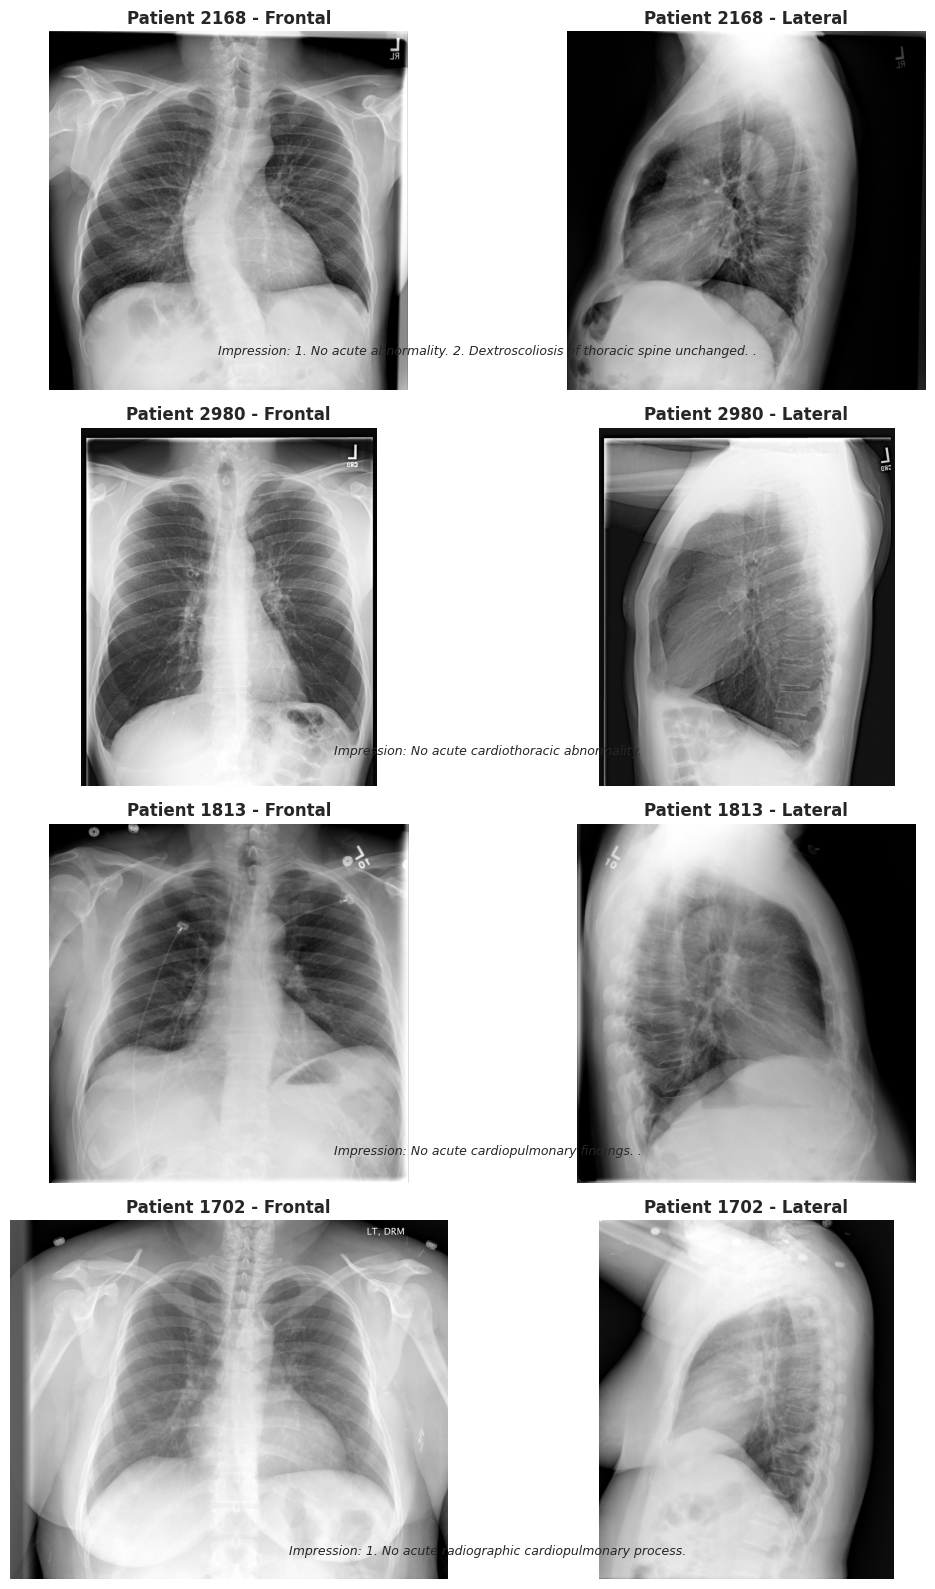

In [15]:
# Visualize sample X-rays with reports
visualize_sample_xrays(
    merged_df,
    data_paths,
    n_samples=4,
    save_path=project_root / 'data' / 'reports' / 'sample_xrays.png'
)

## 5. Text Analysis: Findings vs. Impression

Analyze the two main text fields:
- **Findings**: Detailed radiological observations
- **Impression**: Concise clinical conclusion (recommended target)

In [16]:
# Sample reports
sample_reports = reports_df.sample(5, random_state=42)

print("Sample Reports:")
print("=" * 80)
for idx, row in sample_reports.iterrows():
    print(f"\nPatient {row['uid']}:")
    print(f"  Findings: {row['findings'][:200]}..." if pd.notna(row['findings']) else "  Findings: [None]")
    print(f"  Impression: {row['impression']}" if pd.notna(row['impression']) else "  Impression: [None]")
    print("-" * 80)

Sample Reports:

Patient 2863:
  Findings: The lungs are clear bilaterally. Specifically, no evidence of focal consolidation, pneumothorax, or pleural effusion.. Cardio mediastinal silhouette is unremarkable. Visualized osseous structures of t...
  Impression: No acute cardiopulmonary abnormality..
--------------------------------------------------------------------------------

Patient 472:
  Findings: Normal heart size and mediastinal contours. No focal airspace consolidation. No pleural effusion or pneumothorax. Stable postoperative and degenerative changes of the XXXX. Stable degenerative disc di...
  Impression: No acute cardiopulmonary abnormalities.
--------------------------------------------------------------------------------

Patient 302:
  Findings: Heart size within normal limits, stable mediastinal and hilar contours. No focal alveolar consolidation, no definite pleural effusion seen. No typical findings of pulmonary edema. Mild spine curvature...
  Impression: No acute f

In [17]:
# Analyze missing values in text fields
text_missing = pd.DataFrame({
    'Field': ['findings', 'impression'],
    'Missing': [reports_df['findings'].isnull().sum(), reports_df['impression'].isnull().sum()],
    'Missing %': [
        reports_df['findings'].isnull().sum() / len(reports_df) * 100,
        reports_df['impression'].isnull().sum() / len(reports_df) * 100
    ]
})

print("Missing Text Fields:")
display(text_missing)

Missing Text Fields:


,Field,Missing,Missing %
0,findings,514,13.347183
1,impression,31,0.804986


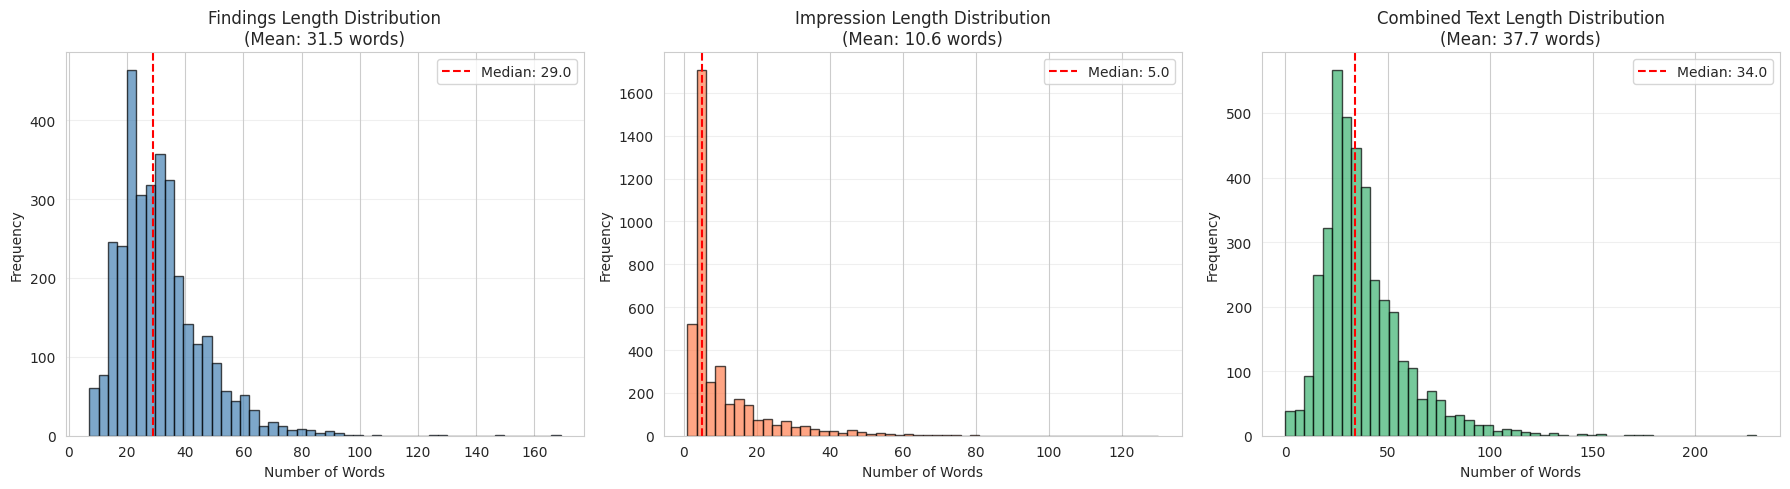

In [18]:
# Plot text length distributions
plot_text_length_distributions(
    reports_df,
    save_path=project_root / 'data' / 'reports' / 'text_length_distributions.png'
)

## 6. Censoring Analysis (XXXX Tokens)

Many reports contain `XXXX` tokens to censor patient information. We need to:
1. Measure the extent of censoring
2. Filter heavily censored reports

In [19]:
# Calculate censoring ratios for findings and impression
reports_df['findings_censoring'] = reports_df['findings'].apply(calculate_censoring_ratio)
reports_df['impression_censoring'] = reports_df['impression'].apply(calculate_censoring_ratio)

# Combined text censoring
reports_df['combined_text'] = reports_df.apply(
    lambda row: extract_report_text(row, use_findings=True, use_impression=True),
    axis=1
)
reports_df['combined_censoring'] = reports_df['combined_text'].apply(calculate_censoring_ratio)

print("Censoring Statistics:")
print("=" * 50)
print(f"Findings - Mean: {reports_df['findings_censoring'].mean():.3f}, Median: {reports_df['findings_censoring'].median():.3f}")
print(f"Impression - Mean: {reports_df['impression_censoring'].mean():.3f}, Median: {reports_df['impression_censoring'].median():.3f}")
print(f"Combined - Mean: {reports_df['combined_censoring'].mean():.3f}, Median: {reports_df['combined_censoring'].median():.3f}")

Censoring Statistics:
Findings - Mean: 0.018, Median: 0.000
Impression - Mean: 0.014, Median: 0.000
Combined - Mean: 0.021, Median: 0.000


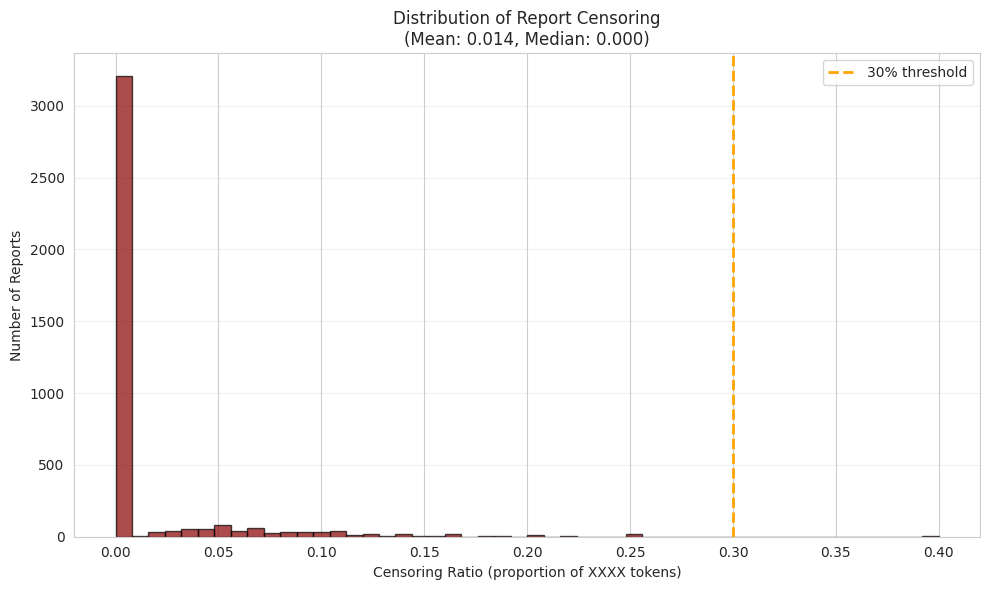

In [20]:
# Plot censoring distribution for impression (our target)
plot_censoring_distribution(
    reports_df['impression_censoring'],
    save_path=project_root / 'data' / 'reports' / 'censoring_distribution.png'
)

In [21]:
# Filter reports based on censoring threshold from config
max_censoring = config['max_censoring_ratio']

print(f"Filtering with max censoring ratio: {max_censoring}")
print(f"Reports before filtering: {len(reports_df)}")

# Filter based on impression censoring (our target field)
reports_filtered = reports_df[reports_df['impression_censoring'] <= max_censoring].copy()

print(f"Reports after filtering: {len(reports_filtered)}")
print(f"Reports removed: {len(reports_df) - len(reports_filtered)} ({(len(reports_df) - len(reports_filtered))/len(reports_df)*100:.1f}%)")

Filtering with max censoring ratio: 0.3
Reports before filtering: 3851
Reports after filtering: 3848
Reports removed: 3 (0.1%)


## 7. N-gram Analysis

Analyze unigrams, bigrams, and trigrams to understand:
- Most common medical terms
- Standard phrases in radiology reports
- Vocabulary characteristics

In [ ]:
# Use impression field as our target (per config)
impression_texts = reports_filtered['impression'].dropna().tolist()

print(f"Analyzing {len(impression_texts)} impression texts")
print(f"Sample: {impression_texts[0][:150]}...")

Analyzing 3817 impression texts
Sample: Normal chest x-XXXX....


### 7.1 Unigram Analysis (Word Frequencies)

In [23]:
# Get unigram frequencies
unigrams = get_ngram_frequencies(impression_texts, n=1, top_k=None, lowercase=True, remove_punctuation=True)

print(f"Total unique unigrams: {len(unigrams)}")
print(f"Total unigram tokens: {sum(unigrams.values())}")
print("\nTop 30 most frequent words:")
for word, count in unigrams.most_common(30):
    print(f"  {word[0]:20s}: {count:6d}")

Total unique unigrams: 1499
Total unigram tokens: 38420

Top 30 most frequent words:
  no                  :   3121
  acute               :   2315
  cardiopulmonary     :   1620
  disease             :   1060
  xxxx                :   1050
  of                  :    926
  the                 :    839
  abnormality         :    814
  and                 :    555
  right               :    547
  normal              :    520
  pulmonary           :    487
  with                :    473
  left                :    462
  findings            :    457
  chest               :    407
  or                  :    406
  lungs               :    400
  is                  :    395
  clear               :    377
  active              :    350
  pleural             :    346
  heart               :    344
  lung                :    339
  process             :    333
  size                :    326
  evidence            :    310
  in                  :    294
  stable              :    288
  are           

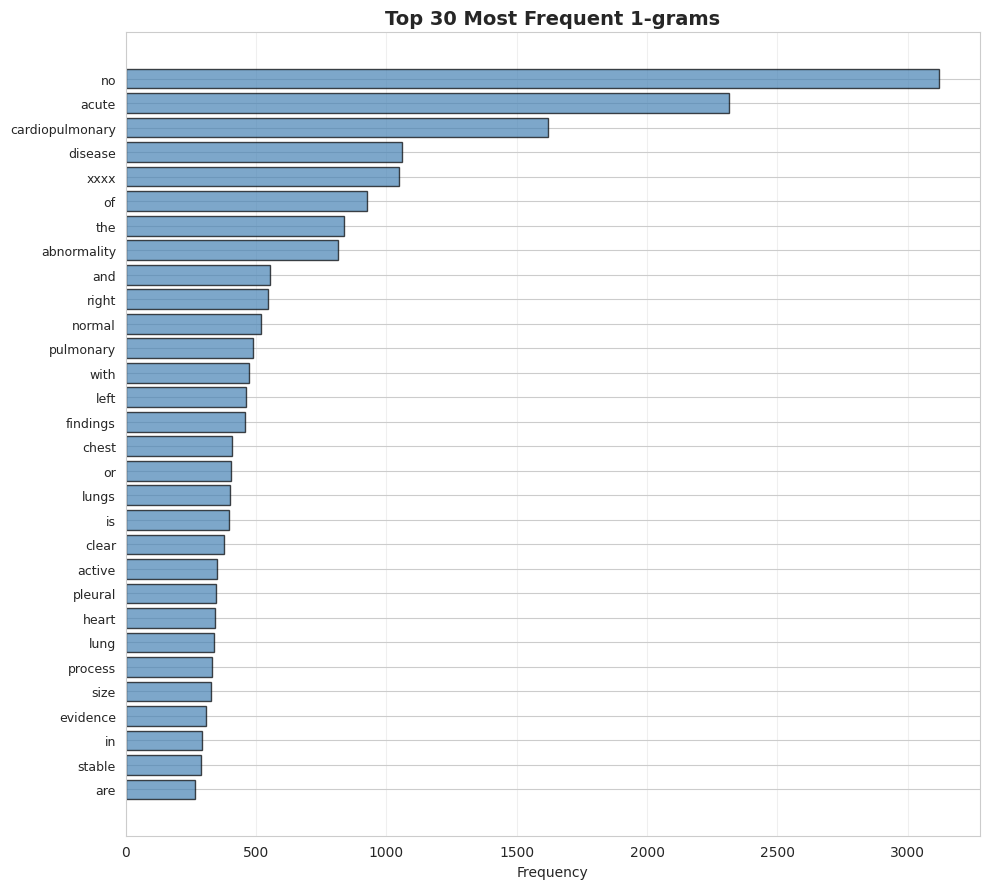

In [24]:
# Visualize top unigrams
plot_ngram_frequencies(
    unigrams,
    n=1,
    top_k=30,
    save_path=project_root / 'data' / 'reports' / 'top_unigrams.png'
)

In [25]:
# Save full unigram report
save_ngram_report(
    unigrams,
    output_path=project_root / 'data' / 'reports' / 'unigrams_full.csv',
    n=1
)

Saved 1499 1-grams to /home/miguel/Desktop/MCIM/Projects/MCIM_Final_Project/data/reports/unigrams_full.csv


### 7.2 Bigram Analysis (2-word phrases)

In [26]:
# Get bigram frequencies
bigrams = get_ngram_frequencies(impression_texts, n=2, top_k=None, lowercase=True, remove_punctuation=True)

print(f"Total unique bigrams: {len(bigrams)}")
print("\nTop 30 most frequent bigrams:")
for bigram, count in bigrams.most_common(30):
    print(f"  {' '.join(bigram):30s}: {count:6d}")

Total unique bigrams: 9207

Top 30 most frequent bigrams:
  no acute                      :   1996
  acute cardiopulmonary         :   1471
  cardiopulmonary abnormality   :    637
  heart size                    :    298
  cardiopulmonary disease       :    293
  evidence of                   :    289
  active disease                :    246
  cardiopulmonary process       :    242
  no evidence                   :    241
  of the                        :    234
  cardiopulmonary findings      :    225
  in the                        :    185
  pleural effusion              :    184
  cardiopulmonary abnormalities :    175
  clear lungs                   :    165
  no active                     :    165
  acute pulmonary               :    160
  acute disease                 :    154
  airspace disease              :    141
  of active                     :    137
  normal limits                 :    127
  lungs are                     :    127
  the right                     :    122

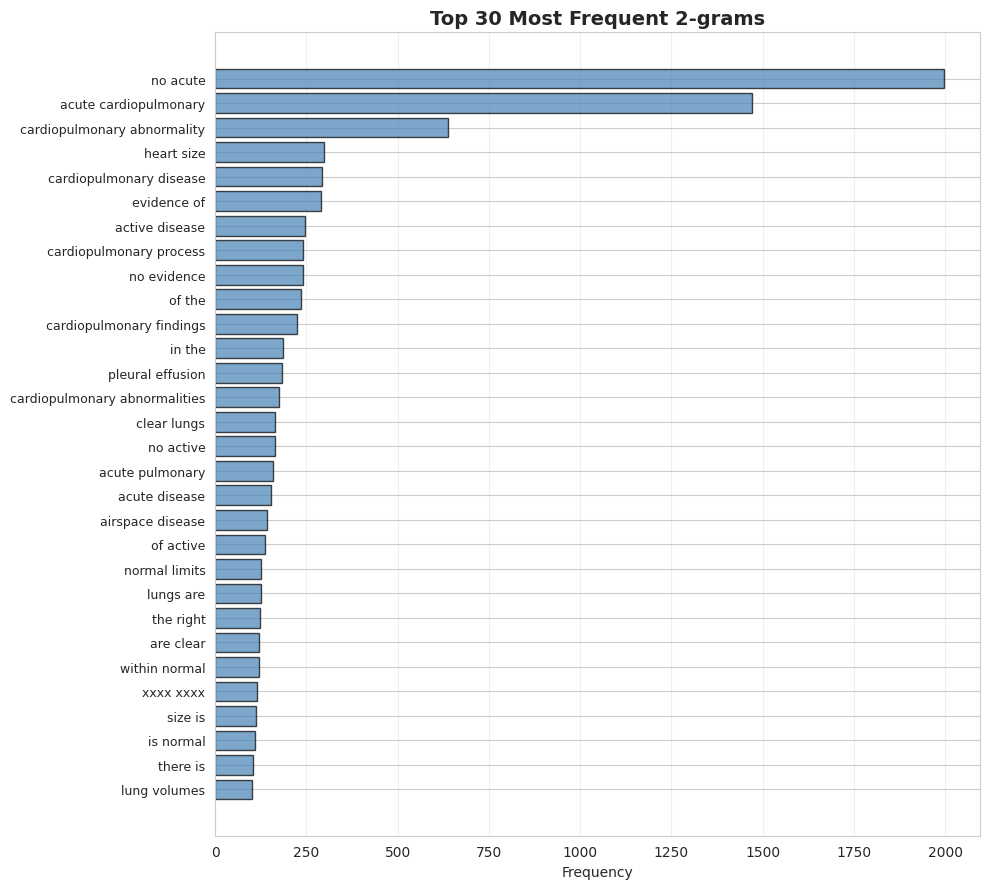

In [27]:
# Visualize top bigrams
plot_ngram_frequencies(
    bigrams,
    n=2,
    top_k=30,
    save_path=project_root / 'data' / 'reports' / 'top_bigrams.png'
)

In [28]:
# Save full bigram report
save_ngram_report(
    bigrams,
    output_path=project_root / 'data' / 'reports' / 'bigrams_full.csv',
    n=2
)

Saved 9207 2-grams to /home/miguel/Desktop/MCIM/Projects/MCIM_Final_Project/data/reports/bigrams_full.csv


### 7.3 Trigram Analysis (3-word phrases)

In [29]:
# Get trigram frequencies
trigrams = get_ngram_frequencies(impression_texts, n=3, top_k=None, lowercase=True, remove_punctuation=True)

print(f"Total unique trigrams: {len(trigrams)}")
print("\nTop 30 most frequent trigrams:")
for trigram, count in trigrams.most_common(30):
    print(f"  {' '.join(trigram):40s}: {count:6d}")

Total unique trigrams: 15882

Top 30 most frequent trigrams:
  no acute cardiopulmonary                :   1302
  acute cardiopulmonary abnormality       :    633
  acute cardiopulmonary disease           :    249
  no evidence of                          :    227
  acute cardiopulmonary findings          :    225
  acute cardiopulmonary abnormalities     :    175
  no acute pulmonary                      :    153
  acute cardiopulmonary process           :    148
  no active disease                       :    148
  no acute disease                        :    128
  evidence of active                      :    122
  within normal limits                    :    119
  lungs are clear                         :    118
  heart size is                           :    112
  size is normal                          :    101
  of active disease                       :     98
  acute radiographic cardiopulmonary      :     95
  no acute findings                       :     94
  no acute radiograph

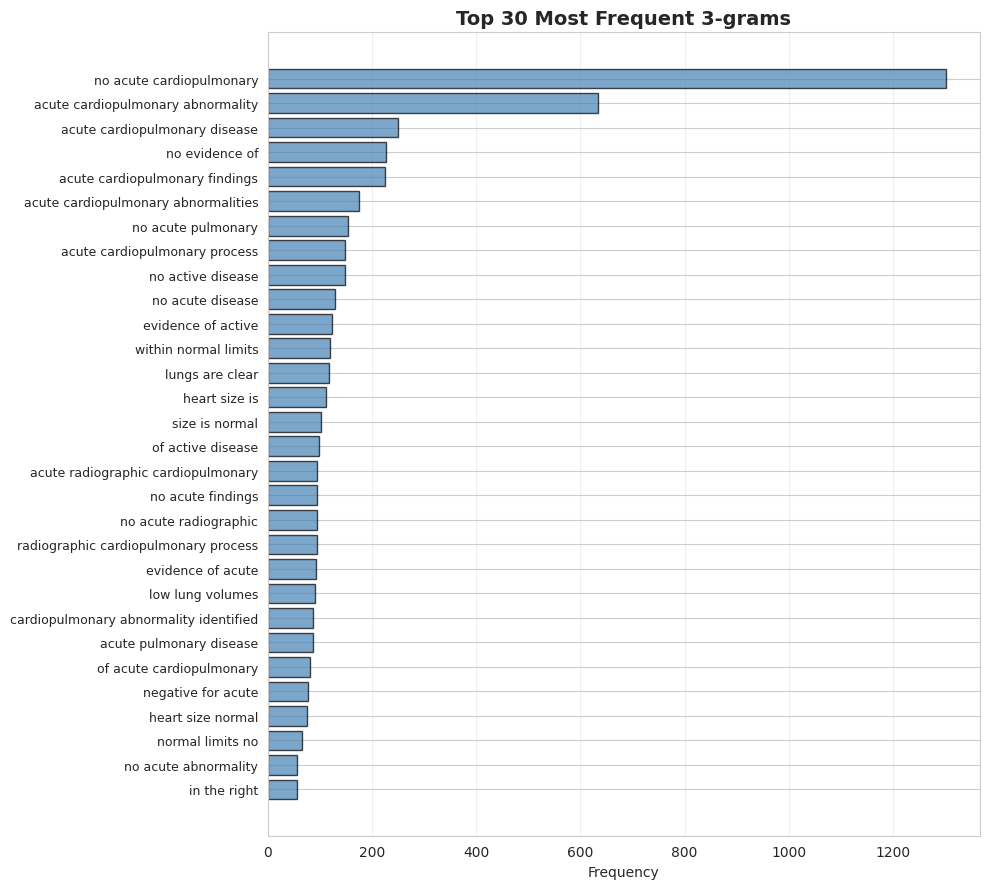

In [30]:
# Visualize top trigrams
plot_ngram_frequencies(
    trigrams,
    n=3,
    top_k=30,
    save_path=project_root / 'data' / 'reports' / 'top_trigrams.png'
)

In [31]:
# Save full trigram report
save_ngram_report(
    trigrams,
    output_path=project_root / 'data' / 'reports' / 'trigrams_full.csv',
    n=3
)

Saved 15882 3-grams to /home/miguel/Desktop/MCIM/Projects/MCIM_Final_Project/data/reports/trigrams_full.csv


## 8. Vocabulary Building

Build vocabulary with different minimum frequency thresholds to understand size vs. coverage trade-offs.

In [32]:
# Build vocabularies with different min_freq thresholds
vocab_stats = []

for min_freq in [3, 4, 5]:
    token_counter, vocab = build_vocabulary(
        impression_texts,
        min_freq=min_freq,
        lowercase=True,
        remove_punctuation=True
    )
    
    total_tokens = sum(token_counter.values())
    vocab_tokens = sum(count for token, count in token_counter.items() if token in vocab)
    coverage = (vocab_tokens / total_tokens) * 100
    
    vocab_stats.append({
        'min_freq': min_freq,
        'vocab_size': len(vocab),
        'coverage_pct': coverage,
        'unique_tokens': len(token_counter)
    })
    
    print(f"\nMin Frequency: {min_freq}")
    print(f"  Vocabulary size: {len(vocab)}")
    print(f"  Coverage: {coverage:.2f}%")
    print(f"  Total unique tokens: {len(token_counter)}")

vocab_comparison = pd.DataFrame(vocab_stats)
display(vocab_comparison)


Min Frequency: 3
  Vocabulary size: 784
  Coverage: 97.57%
  Total unique tokens: 1499

Min Frequency: 4
  Vocabulary size: 671
  Coverage: 96.69%
  Total unique tokens: 1499

Min Frequency: 4
  Vocabulary size: 671
  Coverage: 96.69%
  Total unique tokens: 1499

Min Frequency: 5
  Vocabulary size: 586
  Coverage: 95.80%
  Total unique tokens: 1499

Min Frequency: 5
  Vocabulary size: 586
  Coverage: 95.80%
  Total unique tokens: 1499


,min_freq,vocab_size,coverage_pct,unique_tokens
0,3,784,97.571577,1499
1,4,671,96.689224,1499
2,5,586,95.804269,1499


In [33]:
# Build final vocabulary with configured min_freq
min_freq = config['min_vocab_freq']
print(f"Building final vocabulary with min_freq={min_freq}")

token_counter, vocab = build_vocabulary(
    impression_texts,
    min_freq=min_freq,
    lowercase=True,
    remove_punctuation=True
)

print(f"\nFinal vocabulary size: {len(vocab)}")
print(f"Special tokens: <PAD>, <START>, <END>, <UNK>")
print(f"\nMost common tokens (excluding special tokens):")
for token, idx in list(vocab.items())[4:24]:  # Skip special tokens
    count = token_counter[token]
    print(f"  {token:20s} (idx={idx:4d}): {count:6d}")

Building final vocabulary with min_freq=5

Final vocabulary size: 586
Special tokens: <PAD>, <START>, <END>, <UNK>

Most common tokens (excluding special tokens):
  no                   (idx=   4):   3121
  acute                (idx=   5):   2315
  cardiopulmonary      (idx=   6):   1620
  disease              (idx=   7):   1060
  xxxx                 (idx=   8):   1050
  of                   (idx=   9):    926
  the                  (idx=  10):    839
  abnormality          (idx=  11):    814
  and                  (idx=  12):    555
  right                (idx=  13):    547
  normal               (idx=  14):    520
  pulmonary            (idx=  15):    487
  with                 (idx=  16):    473
  left                 (idx=  17):    462
  findings             (idx=  18):    457
  chest                (idx=  19):    407
  or                   (idx=  20):    406
  lungs                (idx=  21):    400
  is                   (idx=  22):    395
  clear                (idx=  23):    3

In [34]:
# Save vocabulary
from src.data.text_preprocessing import save_vocabulary

vocab_path = project_root / 'data' / 'processed' / 'vocabulary.txt'
save_vocabulary(vocab, token_counter, vocab_path)

print(f"Vocabulary saved to: {vocab_path}")

Vocabulary saved to: /home/miguel/Desktop/MCIM/Projects/MCIM_Final_Project/data/processed/vocabulary.txt


In [35]:
# Analyze token frequency distribution
freq_counts = Counter([count for count in token_counter.values()])

print("Token frequency distribution:")
print(f"  Tokens appearing once: {freq_counts[1]}")
print(f"  Tokens appearing 2 times: {freq_counts[2]}")
print(f"  Tokens appearing 3-5 times: {sum(freq_counts[i] for i in range(3, 6))}")
print(f"  Tokens appearing 6-10 times: {sum(freq_counts[i] for i in range(6, 11))}")
print(f"  Tokens appearing >10 times: {sum(freq_counts[i] for i in range(11, max(freq_counts.keys())+1))}")

Token frequency distribution:
  Tokens appearing once: 505
  Tokens appearing 2 times: 214
  Tokens appearing 3-5 times: 246
  Tokens appearing 6-10 times: 171
  Tokens appearing >10 times: 363


## 9. Export Cleaned Data Summary

Save key statistics and filtered data for next steps.

In [36]:
# Save summary statistics
summary = {
    'dataset_stats': {
        'total_patients': proj_stats['total_patients'],
        'total_images': len(projections_df),
        'total_reports': len(reports_df),
        'ideal_pairs': proj_stats['ideal_pairs'],
        'frontal_only': proj_stats['frontal_only'],
    },
    'text_stats': {
        'reports_before_filtering': len(reports_df),
        'reports_after_filtering': len(reports_filtered),
        'avg_impression_length_words': reports_filtered['impression'].dropna().apply(lambda x: len(str(x).split())).mean(),
        'avg_findings_length_words': reports_filtered['findings'].dropna().apply(lambda x: len(str(x).split())).mean(),
    },
    'vocabulary_stats': {
        'vocab_size': len(vocab),
        'min_freq': min_freq,
        'total_unique_tokens': len(token_counter),
    },
    'config': config
}

import json
summary_path = project_root / 'data' / 'reports' / 'eda_summary.json'
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)

print(f"Summary saved to: {summary_path}")
print("\nEDA Complete!")

Summary saved to: /home/miguel/Desktop/MCIM/Projects/MCIM_Final_Project/data/reports/eda_summary.json

EDA Complete!
